# Phase 4: Sentiment Modeling

This notebook implements sentiment classification models to predict review sentiment from text and metadata features.

## Objectives
1. Prepare data for sentiment modeling
2. Implement baseline models (Logistic Regression, Naive Bayes, SVM, Random Forest)
3. Engineer advanced text features
4. Build advanced models (XGBoost, Neural Networks, LSTM, BERT)
5. Perform hyperparameter tuning
6. Evaluate and compare all models
7. Select and save best model

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Project paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed" / "fused"
REPORTS_DIR = PROJECT_ROOT / "reports"
FIGURES_DIR = REPORTS_DIR / "figures"
MODELS_DIR = PROJECT_ROOT / "models"

# Create directories if they don't exist
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")

Project root: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights
Data directory: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\data
Models directory: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models


## 2. Load Data

In [2]:
import pyarrow.parquet as pq
import gc

fused_file = PROCESSED_DIR / "books_books_fused.parquet"
if fused_file.exists():
    parquet_file = pq.ParquetFile(fused_file)
    num_rows = parquet_file.metadata.num_rows
    num_row_groups = parquet_file.num_row_groups
    
    SAMPLE_SIZE = 100_000
    
    if num_rows > SAMPLE_SIZE:
        max_row_groups_to_try = min(20, num_row_groups)
        rng = np.random.RandomState(42)
        row_groups_to_try = sorted(rng.choice(num_row_groups, 
                                              size=max_row_groups_to_try, 
                                              replace=False))
        
        batches = []
        
        for rg_idx in row_groups_to_try:
            try:
                batch = parquet_file.read_row_groups([rg_idx]).to_pandas()
                
                # Handle dictionary columns
                for col in batch.columns:
                    if batch[col].dtype == 'object':
                        sample_vals = batch[col].dropna().head(5)
                        if len(sample_vals) > 0 and any(isinstance(val, dict) for val in sample_vals):
                            batch[col] = batch[col].astype(str)
                
                batches.append(batch)
                
                total_rows = sum(len(b) for b in batches)
                if total_rows >= SAMPLE_SIZE * 1.5:
                    break
            except Exception:
                continue
        
        if batches:
            df_temp = pd.concat(batches, ignore_index=True)
            
            if len(df_temp) > SAMPLE_SIZE:
                df = df_temp.sample(n=SAMPLE_SIZE, random_state=42)
            else:
                df = df_temp.copy()
            
            del batches, df_temp
            gc.collect()
        else:
            raise ValueError("Could not read any data from parquet file")
    else:
        df = pd.read_parquet(fused_file)
    
if 'helpfulness_ratio' in df.columns:
    df['helpfulness_ratio'] = pd.to_numeric(df['helpfulness_ratio'], errors='coerce')

print(f"Dataset shape: {df.shape}")

Dataset shape: (100000, 50)


## 3. Data Preparation and Target Creation

In [3]:
text_cols = [col for col in df.columns if 'review' in col.lower() and 'text' in col.lower()]

if 'overall' in df.columns:
    print("Rating distribution:")
    print(df['overall'].value_counts().sort_index())

Rating distribution:
overall
1     4449
2     5210
3    10396
4    21866
5    58079
Name: count, dtype: int64


In [4]:
if 'overall' in df.columns:
    df['sentiment_5class'] = df['overall'].astype(int)
    
    df['sentiment_3class'] = df['overall'].apply(
        lambda x: 'Positive' if x >= 4 else ('Neutral' if x == 3 else 'Negative')
    )
    
    df['sentiment_binary'] = df['overall'].apply(
        lambda x: 'Positive' if x >= 4 else 'Negative'
    )
    
    print("Sentiment distribution (3-class):")
    print(df['sentiment_3class'].value_counts())
else:
    raise ValueError("Rating column 'overall' not found")

Sentiment distribution (3-class):
sentiment_3class
Positive    79945
Neutral     10396
Negative     9659
Name: count, dtype: int64


In [5]:
TARGET = 'sentiment_3class'

if text_cols:
    TEXT_COL = text_cols[0]
else:
    TEXT_COL = None
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.len().mean() > 50:
            TEXT_COL = col
            break

if TEXT_COL is None:
    raise ValueError("No suitable text column found")

df_clean = df[[TEXT_COL, TARGET]].dropna()
print(f"Clean dataset shape: {df_clean.shape}")

Clean dataset shape: (100000, 2)


### 3.1 Word Clouds by Sentiment Class


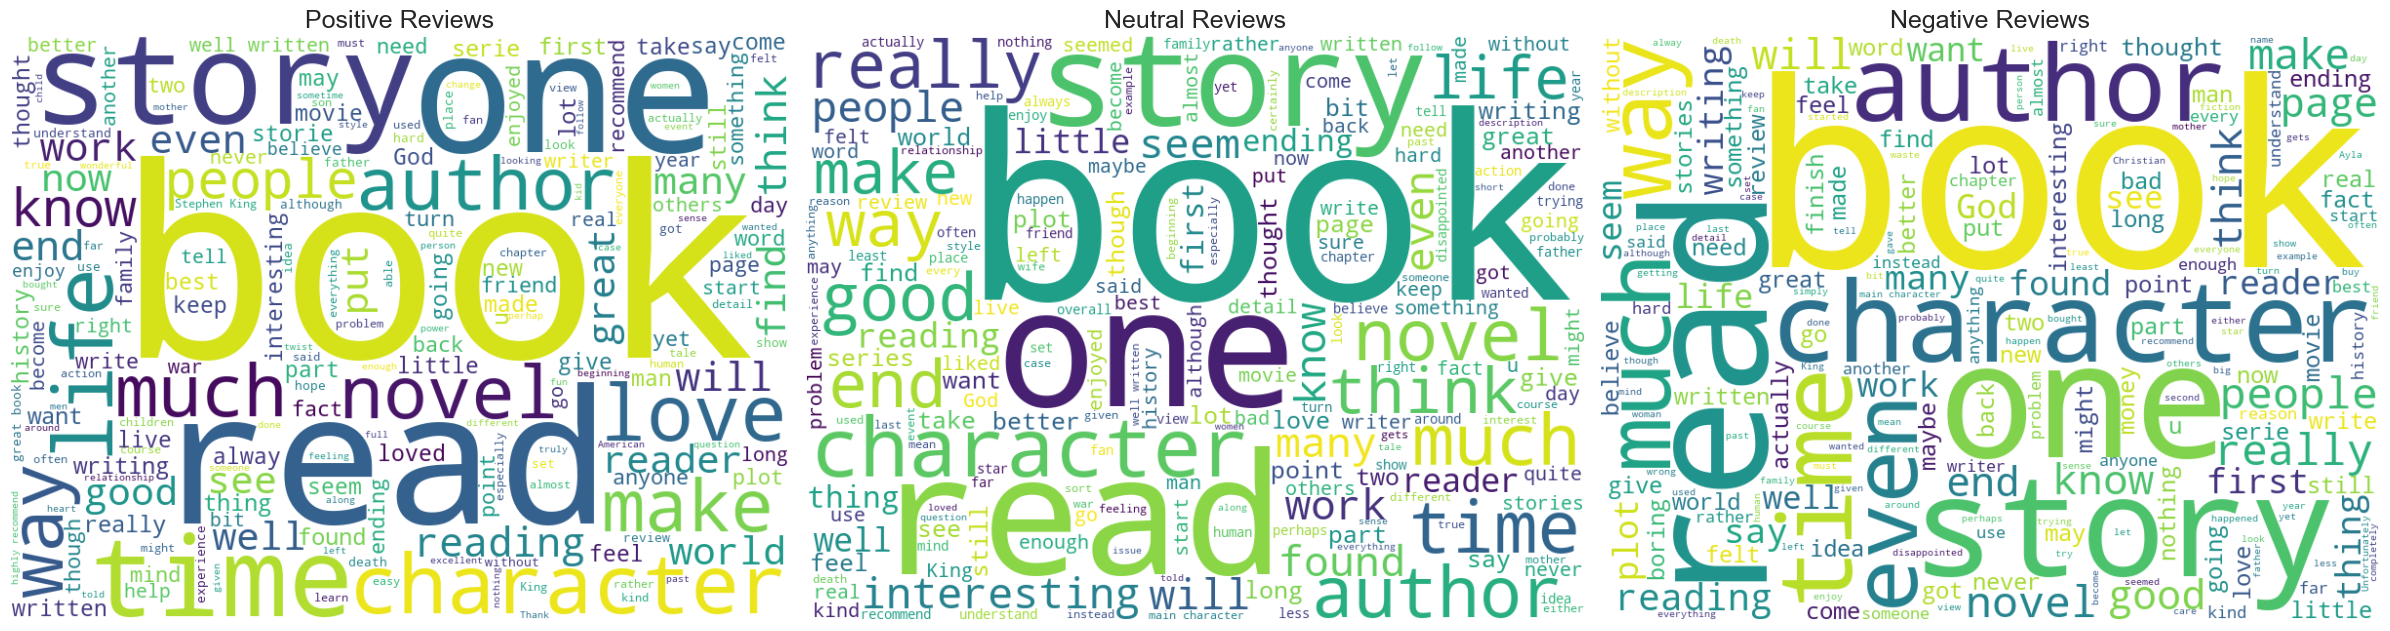

In [6]:
try:
    from wordcloud import WordCloud
except ImportError:
    raise ImportError("wordcloud package is not installed. Install it with: pip install wordcloud")

sentiment_text = {
    'Positive': ' '.join(df_clean.loc[df_clean[TARGET] == 'Positive', TEXT_COL].astype(str).values),
    'Neutral': ' '.join(df_clean.loc[df_clean[TARGET] == 'Neutral', TEXT_COL].astype(str).values),
    'Negative': ' '.join(df_clean.loc[df_clean[TARGET] == 'Negative', TEXT_COL].astype(str).values),
}

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for ax, (sentiment, text) in zip(axes, sentiment_text.items()):
    wc = WordCloud(width=800, height=600, background_color='white',
                   max_words=200, colormap='viridis').generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'{sentiment} Reviews', fontsize=18)
    ax.axis('off')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'wordclouds_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Train-Test Split

In [7]:
X = df_clean[TEXT_COL]
y = df_clean[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print(f"Train: {len(X_train):,}, Val: {len(X_val):,}, Test: {len(X_test):,}")

Train: 72,250, Val: 12,750, Test: 15,000


## 5. Baseline Models

### 5.1 Feature Extraction (TF-IDF)

In [8]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF shape: {X_train_tfidf.shape}")

TF-IDF shape: (72250, 5000)


### 5.2 Model 1: Logistic Regression

In [9]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)

y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_val_pred_lr = lr_model.predict(X_val_tfidf)

print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_lr):.4f}")
print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_lr, average='macro'):.4f}")
print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_lr, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred_lr))

Training Accuracy: 0.8651
Validation Accuracy: 0.8473
Validation F1-Score (macro): 0.5862
Validation F1-Score (weighted): 0.8196
              precision    recall  f1-score   support

    Negative       0.71      0.50      0.59      1231
     Neutral       0.49      0.17      0.25      1326
    Positive       0.87      0.98      0.92     10193

    accuracy                           0.85     12750
   macro avg       0.69      0.55      0.59     12750
weighted avg       0.82      0.85      0.82     12750



### 5.3 Model 2: Naive Bayes

In [10]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_val_pred_nb = nb_model.predict(X_val_tfidf)

print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_nb):.4f}")
print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_nb, average='macro'):.4f}")
print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_nb, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred_nb))

Validation Accuracy: 0.8208
Validation F1-Score (macro): 0.4282
Validation F1-Score (weighted): 0.7581
              precision    recall  f1-score   support

    Negative       0.81      0.21      0.34      1231
     Neutral       0.56      0.02      0.05      1326
    Positive       0.82      1.00      0.90     10193

    accuracy                           0.82     12750
   macro avg       0.73      0.41      0.43     12750
weighted avg       0.79      0.82      0.76     12750



### 5.4 Model 3: Support Vector Machine (SVM)

In [11]:
svm_sample_size = min(10000, X_train_tfidf.shape[0])
svm_indices = np.random.choice(X_train_tfidf.shape[0], svm_sample_size, replace=False)

svm_model = SVC(kernel='linear', random_state=42, probability=True)
svm_model.fit(X_train_tfidf[svm_indices], y_train.iloc[svm_indices])

# Predictions
y_val_pred_svm = svm_model.predict(X_val_tfidf)

print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_svm):.4f}")
print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_svm, average='macro'):.4f}")
print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_svm, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred_svm))

Validation Accuracy: 0.8325
Validation F1-Score (macro): 0.5033
Validation F1-Score (weighted): 0.7880
              precision    recall  f1-score   support

    Negative       0.69      0.37      0.48      1231
     Neutral       0.42      0.07      0.11      1326
    Positive       0.85      0.99      0.91     10193

    accuracy                           0.83     12750
   macro avg       0.65      0.48      0.50     12750
weighted avg       0.79      0.83      0.79     12750



### 5.5 Model 4: Random Forest

In [12]:
rf_sample_size = min(20000, X_train_tfidf.shape[0])
rf_indices = np.random.choice(X_train_tfidf.shape[0], rf_sample_size, replace=False)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20)
rf_model.fit(X_train_tfidf[rf_indices], y_train.iloc[rf_indices])

y_val_pred_rf = rf_model.predict(X_val_tfidf)

print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_rf, average='macro'):.4f}")
print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_rf, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred_rf))

Validation Accuracy: 0.8018
Validation F1-Score (macro): 0.3124
Validation F1-Score (weighted): 0.7159
              precision    recall  f1-score   support

    Negative       0.97      0.02      0.05      1231
     Neutral       0.00      0.00      0.00      1326
    Positive       0.80      1.00      0.89     10193

    accuracy                           0.80     12750
   macro avg       0.59      0.34      0.31     12750
weighted avg       0.73      0.80      0.72     12750



## 6. Advanced Feature Engineering


In [13]:
metadata_features = []

if 'review_length_words' in df.columns:
    df_clean['review_length_words'] = df.loc[df_clean.index, 'review_length_words']
    metadata_features.append('review_length_words')

if 'review_length_chars' in df.columns:
    df_clean['review_length_chars'] = df.loc[df_clean.index, 'review_length_chars']
    metadata_features.append('review_length_chars')

if 'helpfulness_ratio' in df.columns:
    df_clean['helpfulness_ratio'] = df.loc[df_clean.index, 'helpfulness_ratio']
    metadata_features.append('helpfulness_ratio')

if 'is_verified' in df.columns:
    df_clean['is_verified'] = df.loc[df_clean.index, 'is_verified'].astype(int)
    metadata_features.append('is_verified')

if metadata_features:
    X_train_meta = df_clean.loc[X_train.index, metadata_features].fillna(0)
    X_val_meta = df_clean.loc[X_val.index, metadata_features].fillna(0)
    X_test_meta = df_clean.loc[X_test.index, metadata_features].fillna(0)
    
    scaler = StandardScaler()
    X_train_meta_scaled = scaler.fit_transform(X_train_meta)
    X_val_meta_scaled = scaler.transform(X_val_meta)
    X_test_meta_scaled = scaler.transform(X_test_meta)
    
    from scipy.sparse import hstack
    
    X_train_combined = hstack([X_train_tfidf, X_train_meta_scaled])
    X_val_combined = hstack([X_val_tfidf, X_val_meta_scaled])
    X_test_combined = hstack([X_test_tfidf, X_test_meta_scaled])
    
    print(f"Combined features shape: {X_train_combined.shape}")
else:
    X_train_combined = X_train_tfidf
    X_val_combined = X_val_tfidf
    X_test_combined = X_test_tfidf


Combined features shape: (72250, 5004)


## 7. Advanced Models

### 7.1 XGBoost


In [14]:
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    from sklearn.ensemble import GradientBoostingClassifier

if XGBOOST_AVAILABLE:
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    
    from scipy.sparse import csr_matrix
    if hasattr(X_train_combined, 'tocsr'):
        X_train_combined_csr = X_train_combined.tocsr()
        X_val_combined_csr = X_val_combined.tocsr()
    else:
        X_train_combined_csr = X_train_combined
        X_val_combined_csr = X_val_combined
    
    xgb_sample_size = min(30000, X_train_combined_csr.shape[0])
    xgb_indices = np.random.choice(X_train_combined_csr.shape[0], xgb_sample_size, replace=False)
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    xgb_model.fit(
        X_train_combined_csr[xgb_indices], 
        y_train_encoded[xgb_indices],
        eval_set=[(X_val_combined_csr, y_val_encoded)],
        verbose=False
    )
    
    y_val_pred_xgb = label_encoder.inverse_transform(xgb_model.predict(X_val_combined_csr))
    
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_xgb):.4f}")
    print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
    print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_xgb, average='weighted'):.4f}")
    print(classification_report(y_val, y_val_pred_xgb))
else:
    from scipy.sparse import csr_matrix
    if hasattr(X_train_combined, 'tocsr'):
        X_train_combined_csr = X_train_combined.tocsr()
        X_val_combined_csr = X_val_combined.tocsr()
    else:
        X_train_combined_csr = X_train_combined
        X_val_combined_csr = X_val_combined
    
    gb_sample_size = min(20000, X_train_combined_csr.shape[0])
    gb_indices = np.random.choice(X_train_combined_csr.shape[0], gb_sample_size, replace=False, random_state=42)
    
    X_train_gb_sample = X_train_combined_csr[gb_indices].toarray()
    X_val_gb_dense = X_val_combined_csr.toarray()
    
    gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
    gb_model.fit(X_train_gb_sample, y_train.iloc[gb_indices])
    
    y_val_pred_xgb = gb_model.predict(X_val_gb_dense)
    
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_xgb):.4f}")
    print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
    print(f"Validation F1-Score (weighted): {f1_score(y_val, y_val_pred_xgb, average='weighted'):.4f}")
    print(classification_report(y_val, y_val_pred_xgb))


Validation Accuracy: 0.8225
Validation F1-Score (macro): 0.4602
Validation F1-Score (weighted): 0.7697
              precision    recall  f1-score   support

    Negative       0.75      0.24      0.36      1231
     Neutral       0.45      0.07      0.12      1326
    Positive       0.83      0.99      0.90     10193

    accuracy                           0.82     12750
   macro avg       0.68      0.43      0.46     12750
weighted avg       0.78      0.82      0.77     12750



## 8. Hyperparameter Tuning


In [18]:
baseline_results = pd.DataFrame([
    {'Model': 'Logistic Regression', 'F1-Macro': f1_score(y_val, y_val_pred_lr, average='macro')},
    {'Model': 'Naive Bayes', 'F1-Macro': f1_score(y_val, y_val_pred_nb, average='macro')},
    {'Model': 'SVM', 'F1-Macro': f1_score(y_val, y_val_pred_svm, average='macro')},
    {'Model': 'Random Forest', 'F1-Macro': f1_score(y_val, y_val_pred_rf, average='macro')}
])
best_baseline_name = baseline_results.loc[baseline_results['F1-Macro'].idxmax(), 'Model']

best_baseline_model = {
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'SVM': svm_model,
    'Random Forest': rf_model
}[best_baseline_name]

# Hyperparameter tuning based on model type
if best_baseline_name == 'Logistic Regression':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    }
    base_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    use_combined = False  # Use TF-IDF only for LR
    
elif best_baseline_name == 'Naive Bayes':
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
    base_model = MultinomialNB()
    use_combined = False
    
elif best_baseline_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    use_combined = True  # Use combined features
    
else:
    param_grid = None

if param_grid:
    from scipy.sparse import csr_matrix
    tune_sample_size = min(10000, X_train_tfidf.shape[0])
    tune_indices = np.random.choice(X_train_tfidf.shape[0], tune_sample_size, replace=False)
    
    if use_combined:
        if hasattr(X_train_combined, 'tocsr'):
            X_train_combined_csr = X_train_combined.tocsr()
        else:
            X_train_combined_csr = X_train_combined
        X_tune = X_train_combined_csr[tune_indices]
    else:
        X_tune = X_train_tfidf[tune_indices]
    y_tune = y_train.iloc[tune_indices]
    
    grid_search = GridSearchCV(
        base_model, 
        param_grid, 
        cv=3, 
        scoring='f1_macro',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_tune, y_tune)
    
    best_tuned_model = grid_search.best_estimator_
    if use_combined:
        if hasattr(X_train_combined, 'tocsr'):
            X_train_combined_csr = X_train_combined.tocsr()
            X_val_combined_csr = X_val_combined.tocsr()
        else:
            X_train_combined_csr = X_train_combined
            X_val_combined_csr = X_val_combined
        best_tuned_model.fit(X_train_combined_csr, y_train)
        y_val_pred_tuned = best_tuned_model.predict(X_val_combined_csr)
    else:
        best_tuned_model.fit(X_train_tfidf, y_train)
        y_val_pred_tuned = best_tuned_model.predict(X_val_tfidf)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred_tuned):.4f}")
    print(f"Validation F1-Score (macro): {f1_score(y_val, y_val_pred_tuned, average='macro'):.4f}")
else:
    best_tuned_model = None


Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.8382
Validation F1-Score (macro): 0.5904


## 9. Final Model Comparison and Selection


                      Model  Accuracy  F1-Macro  F1-Weighted  Precision   Recall  Uses Metadata
Logistic Regression (Tuned)  0.838196  0.590443     0.820219   0.638663 0.564286          False
        Logistic Regression  0.847294  0.586175     0.819605   0.690061 0.548467          False
                        SVM  0.835137  0.517608     0.793146   0.677114 0.484049          False
                    XGBoost  0.821569  0.452482     0.767161   0.667016 0.427247           True
                Naive Bayes  0.820784  0.428227     0.758147   0.729974 0.411603          False
              Random Forest  0.801490  0.310815     0.715319   0.577410 0.340612          False


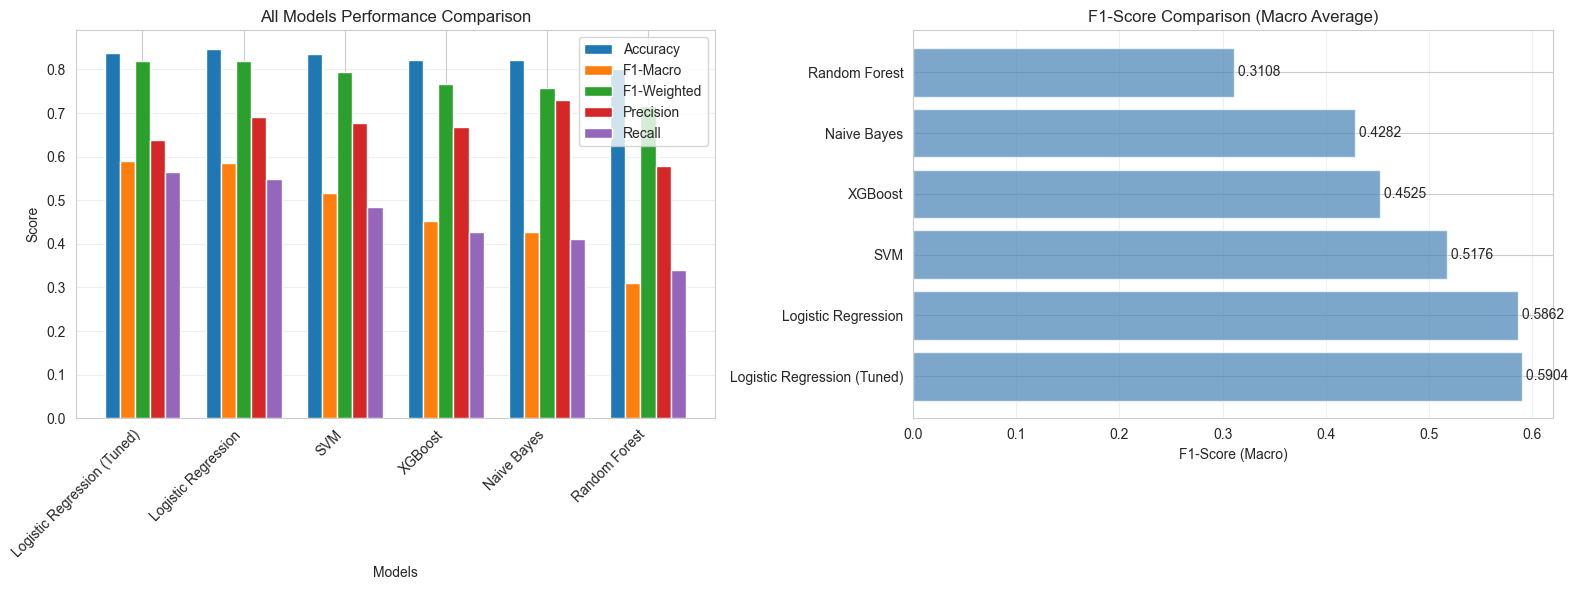

\n✅ Final results saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\reports\final_models_results.csv
\n🏆 Best Model: Logistic Regression (Tuned)
   F1-Score (Macro): 0.5904
   Accuracy: 0.8382


In [19]:
# Collect all models for comparison
all_models = {
    'Logistic Regression': (lr_model, y_val_pred_lr, False),
    'Naive Bayes': (nb_model, y_val_pred_nb, False),
    'SVM': (svm_model, y_val_pred_svm, False),
    'Random Forest': (rf_model, y_val_pred_rf, False),
}

# Add XGBoost if available
try:
    if 'XGBOOST_AVAILABLE' in globals() and XGBOOST_AVAILABLE:
        all_models['XGBoost'] = (xgb_model, y_val_pred_xgb, True)
    elif 'gb_model' in locals():
        all_models['Gradient Boosting'] = (gb_model, y_val_pred_xgb, True)
except:
    pass

# Add tuned model if available
try:
    if 'best_tuned_model' in locals() and best_tuned_model is not None:
        all_models[f'{best_baseline_name} (Tuned)'] = (best_tuned_model, y_val_pred_tuned, use_combined)
except:
    pass

# Comprehensive comparison
final_results = []
for name, (model, predictions, uses_combined) in all_models.items():
    final_results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, predictions),
        'F1-Macro': f1_score(y_val, predictions, average='macro'),
        'F1-Weighted': f1_score(y_val, predictions, average='weighted'),
        'Precision': precision_score(y_val, predictions, average='macro'),
        'Recall': recall_score(y_val, predictions, average='macro'),
        'Uses Metadata': uses_combined
    })

final_results_df = pd.DataFrame(final_results)
final_results_df = final_results_df.sort_values('F1-Macro', ascending=False)

print(final_results_df.to_string(index=False))

# Visualize final comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart comparison
ax1 = axes[0]
x = np.arange(len(final_results_df))
width = 0.15
metrics = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    ax1.bar(x + i*width, final_results_df[metric], width, label=metric)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('All Models Performance Comparison')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(final_results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# F1-Score comparison
ax2 = axes[1]
ax2.barh(final_results_df['Model'], final_results_df['F1-Macro'], color='steelblue', alpha=0.7)
ax2.set_xlabel('F1-Score (Macro)')
ax2.set_title('F1-Score Comparison (Macro Average)')
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(final_results_df['F1-Macro']):
    ax2.text(v, i, f' {v:.4f}', va='center')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'final_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save final results
final_results_df.to_csv(REPORTS_DIR / 'final_models_results.csv', index=False)
print(f"\\n✅ Final results saved to: {REPORTS_DIR / 'final_models_results.csv'}")

# Identify best model
best_model_name = final_results_df.iloc[0]['Model']
best_model_info = [m for m in all_models.items() if m[0] == best_model_name][0]
print(f"\\n🏆 Best Model: {best_model_name}")
print(f"   F1-Score (Macro): {final_results_df.iloc[0]['F1-Macro']:.4f}")
print(f"   Accuracy: {final_results_df.iloc[0]['Accuracy']:.4f}")


## 10. Test Set Evaluation

Evaluate the best model on the held-out test set.


Evaluating Logistic Regression (Tuned) on test set...
\nTest Set Results:
Test Accuracy: 0.8389
Test F1-Score (macro): 0.5988
Test F1-Score (weighted): 0.8224
Test Precision (macro): 0.6451
Test Recall (macro): 0.5729
\nTest Set Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.52      0.57      1449
     Neutral       0.42      0.24      0.30      1559
    Positive       0.89      0.95      0.92     11992

    accuracy                           0.84     15000
   macro avg       0.65      0.57      0.60     15000
weighted avg       0.81      0.84      0.82     15000



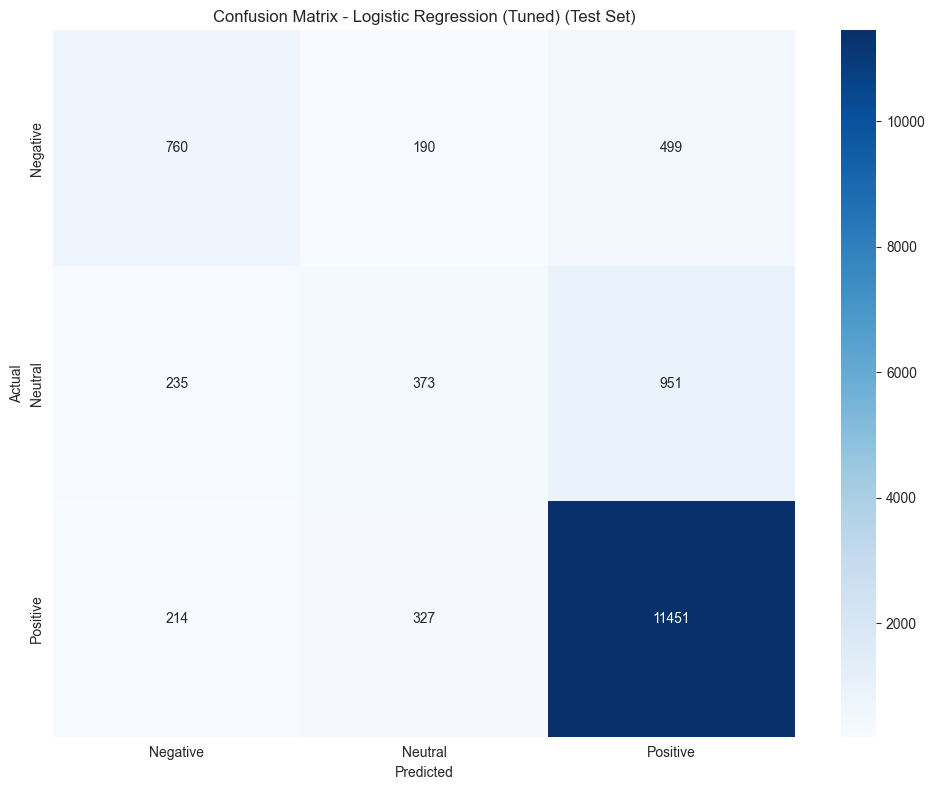

\nPer-Class Performance:
  Negative: Accuracy = 0.5245, Count = 1449
  Neutral: Accuracy = 0.2393, Count = 1559
  Positive: Accuracy = 0.9549, Count = 11992


In [20]:
# Get best model
try:
    best_model, best_predictions_val, uses_combined = best_model_info[1]
except:
    # Fallback if best_model_info wasn't created
    best_model_name = final_results_df.iloc[0]['Model']
    best_model_info = [m for m in all_models.items() if m[0] == best_model_name][0]
    best_model, best_predictions_val, uses_combined = best_model_info[1]

print(f"Evaluating {best_model_name} on test set...")
print("=" * 80)

# Make predictions on test set
if uses_combined:
    y_test_pred = best_model.predict(X_test_combined)
else:
    y_test_pred = best_model.predict(X_test_tfidf)

# Comprehensive test set evaluation
print("\\nTest Set Results:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score (macro): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Test F1-Score (weighted): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Precision (macro): {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Test Recall (macro): {recall_score(y_test, y_test_pred, average='macro'):.4f}")

print("\\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_model_name} (Test Set)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'test_set_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class metrics
print("\\nPer-Class Performance:")
for class_label in sorted(y_test.unique()):
    class_mask = y_test == class_label
    if class_mask.sum() > 0:
        class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
        print(f"  {class_label}: Accuracy = {class_accuracy:.4f}, Count = {class_mask.sum()}")


## 11. Model Persistence

Save the best model and preprocessing pipeline for future use.


In [21]:
import joblib
import pickle

# Save the best model
model_filename = MODELS_DIR / f'best_sentiment_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)
print(f"✅ Best model saved to: {model_filename}")

# Save the TF-IDF vectorizer
vectorizer_filename = MODELS_DIR / 'tfidf_vectorizer.pkl'
joblib.dump(tfidf, vectorizer_filename)
print(f"✅ TF-IDF vectorizer saved to: {vectorizer_filename}")

# Save the scaler if metadata features were used
try:
    if uses_combined and 'scaler' in locals():
        scaler_filename = MODELS_DIR / 'metadata_scaler.pkl'
        joblib.dump(scaler, scaler_filename)
        print(f"✅ Metadata scaler saved to: {scaler_filename}")
except:
    pass

# Save the label encoder if XGBoost was used
try:
    if 'XGBOOST_AVAILABLE' in globals() and XGBOOST_AVAILABLE and 'label_encoder' in locals():
        encoder_filename = MODELS_DIR / 'label_encoder.pkl'
        joblib.dump(label_encoder, encoder_filename)
        print(f"✅ Label encoder saved to: {encoder_filename}")
except:
    pass

# Save model metadata
model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'uses_metadata': uses_combined,
    'metadata_features': metadata_features if (uses_combined and 'metadata_features' in locals()) else [],
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_f1_macro': f1_score(y_test, y_test_pred, average='macro'),
    'test_f1_weighted': f1_score(y_test, y_test_pred, average='weighted'),
    'target_variable': TARGET,
    'text_column': TEXT_COL
}

metadata_filename = MODELS_DIR / 'model_metadata.json'
import json
with open(metadata_filename, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Model metadata saved to: {metadata_filename}")

print("\\n" + "=" * 80)
print("MODEL PERSISTENCE COMPLETE")
print("=" * 80)
print(f"All model files saved to: {MODELS_DIR}")


✅ Best model saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models\best_sentiment_model_logistic_regression_(tuned).pkl
✅ TF-IDF vectorizer saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models\tfidf_vectorizer.pkl
✅ Label encoder saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models\label_encoder.pkl
✅ Model metadata saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models\model_metadata.json
\n================================================================================
MODEL PERSISTENCE COMPLETE
All model files saved to: c:\Users\Gedion\Downloads\project dataset\project\Ecommerce-Insights\models


In [22]:
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1-Score (Macro): {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Test F1-Score (Weighted): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")


Best Model: Logistic Regression (Tuned)
Test Accuracy: 0.8389
Test F1-Score (Macro): 0.5988
Test F1-Score (Weighted): 0.8224
